Visualize Pretrained DINOv3 models on animal videos

In [1]:
import sys
from pathlib import Path
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import yaml
import safetensors

from transformers import AutoImageProcessor, AutoModel
from transformers.image_utils import load_image
from torchvision.transforms import v2

# Add src directory to Python path
# Find project root by looking for src directory
current = Path().resolve()
while current != current.parent:
    src_dir = current / 'src'
    if src_dir.exists() and (src_dir / 'models').exists():
        if str(src_dir) not in sys.path:
            sys.path.insert(0, str(src_dir))
        break
    current = current.parent

from models.mvt import MultiViewTransformer
from data.datasets import MVTDataset
# Plot reconstructions and masked ground truth using the utility function
from utils.viz_utils import plot_mvt_reconstructions
from utils.utils import set_seed

set_seed(42)

BASE_DIR = Path('/data/Projects/multi-view')    
DATA_DIR = os.path.join(BASE_DIR, 'data', 'ssl', 'fly-anipose')
PATCH_SIZE = 16

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
original_image = load_image(url)  # Keep original for visualization
# read PIL image to numpy array
original_image = np.array(original_image)
# Explicitly set device for pipeline
device = 0 if torch.cuda.is_available() else -1  # 0 for GPU, -1 for CPU
print(f"Using device: {'GPU (cuda:0)' if device == 0 else 'CPU'}")

dino_processor = AutoImageProcessor.from_pretrained("facebook/dinov3-vitl16-pretrain-lvd1689m")
dino_model = AutoModel.from_pretrained("facebook/dinov3-vitl16-pretrain-lvd1689m")
dino_model.to(device)

def make_transform(resize_size: int = 256):
    to_tensor = v2.ToImage()
    resize = v2.Resize((resize_size, resize_size), antialias=True)
    to_float = v2.ToDtype(torch.float32, scale=True)
    normalize = v2.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
    )
    return v2.Compose([to_tensor, resize, to_float, normalize])

transform = make_transform(resize_size=256)
print(original_image.shape)
input_image = transform(original_image)
input_image = input_image.unsqueeze(0).to(device)
print(input_image.shape)
h,w = input_image.shape[2:]
# resize original image to h,w
original_image = cv2.resize(original_image, (w, h))

with torch.inference_mode():
    outputs = dino_model(pixel_values=input_image)

features = outputs.last_hidden_state

# skip cls, reg tokens
features = features[:, 5:, :]

print(f"Features shape: {features.shape}")



/home/nvidia/miniconda3/envs/mv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-06 19:58:15.270364: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-06 19:58:17,496	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-12-06 19:58:18,069	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


[19:58:18] INFO     (੭｡╹▿╹｡)੭ seed set to 42

loading configuration file preprocessor_config.json from cache at /home/nvidia/.cache/huggingface/hub/models--facebook--dinov3-vitl16-pretrain-lvd1689m/snapshots/ea8dc2863c51be0a264bab82070e3e8836b02d51/preprocessor_config.json
Image processor DINOv3ViTImageProcessorFast {
  "crop_size": null,
  "data_format": "channels_first",
  "default_to_square": true,
  "device": null,
  "disable_grouping": null,
  "do_center_crop": null,
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_pad": null,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "DINOv3ViTImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "input_data_format": null,
  "pad_size": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "return_tensors": null,
  "size": {
    "height": 224,
    "width": 224
  }
}

loading configuration file config.json from cache at /home/nvidia/.cache/huggingface/hub/models--faceboo

Using device: GPU (cuda:0)
(686, 960, 3)
torch.Size([1, 3, 256, 256])
Features shape: torch.Size([1, 256, 1024])


In [2]:
from sklearn.decomposition import PCA

# Convert features to numpy and reshape for PCA
# Features shape: [batch, num_patches, hidden_dim]
features_np = features.cpu().numpy()[0]  # [num_patches, hidden_dim]
print(f"Features for PCA: {features_np.shape}")

# Apply PCA to reduce to 3 components
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_np)  # [num_patches, 3]

print(f"PCA components shape: {features_pca.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")

# Reshape to spatial dimensions
# For ViT-B/16: 224x224 image -> 14x14 patches
num_patches = features_pca.shape[0]
patch_size = int(np.sqrt(num_patches))
assert patch_size * patch_size == num_patches, f"Expected square number of patches, got {num_patches}"

# Reshape each component to spatial grid
pc1 = features_pca[:, 0].reshape(patch_size, patch_size)
pc2 = features_pca[:, 1].reshape(patch_size, patch_size)
pc3 = features_pca[:, 2].reshape(patch_size, patch_size)


Features for PCA: (256, 1024)
PCA components shape: (256, 3)
Explained variance ratio: [0.28425524 0.10885055 0.07793949]
Total explained variance: 0.4710


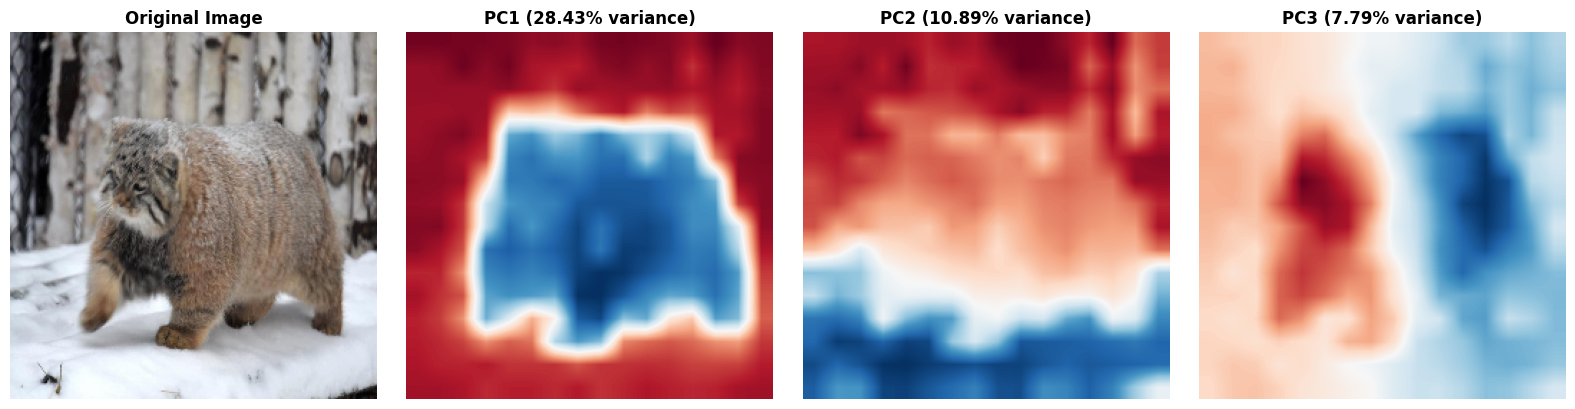

In [3]:
# Visualize original image and PCA components
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Original image
axes[0].imshow(original_image)
axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0].axis('off')

# PCA Component 1
im1 = axes[1].imshow(pc1, cmap='RdBu_r', interpolation='bilinear')
axes[1].set_title(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', 
                  fontsize=12, fontweight='bold')
axes[1].axis('off')
# plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# PCA Component 2
im2 = axes[2].imshow(pc2, cmap='RdBu_r', interpolation='bilinear')
axes[2].set_title(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', 
                  fontsize=12, fontweight='bold')
axes[2].axis('off')
# plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

# PCA Component 3
im3 = axes[3].imshow(pc3, cmap='RdBu_r', interpolation='bilinear')
axes[3].set_title(f'PC3 ({pca.explained_variance_ratio_[2]:.2%} variance)', 
                  fontsize=12, fontweight='bold')
axes[3].axis('off')
# plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


(256, 256, 3)


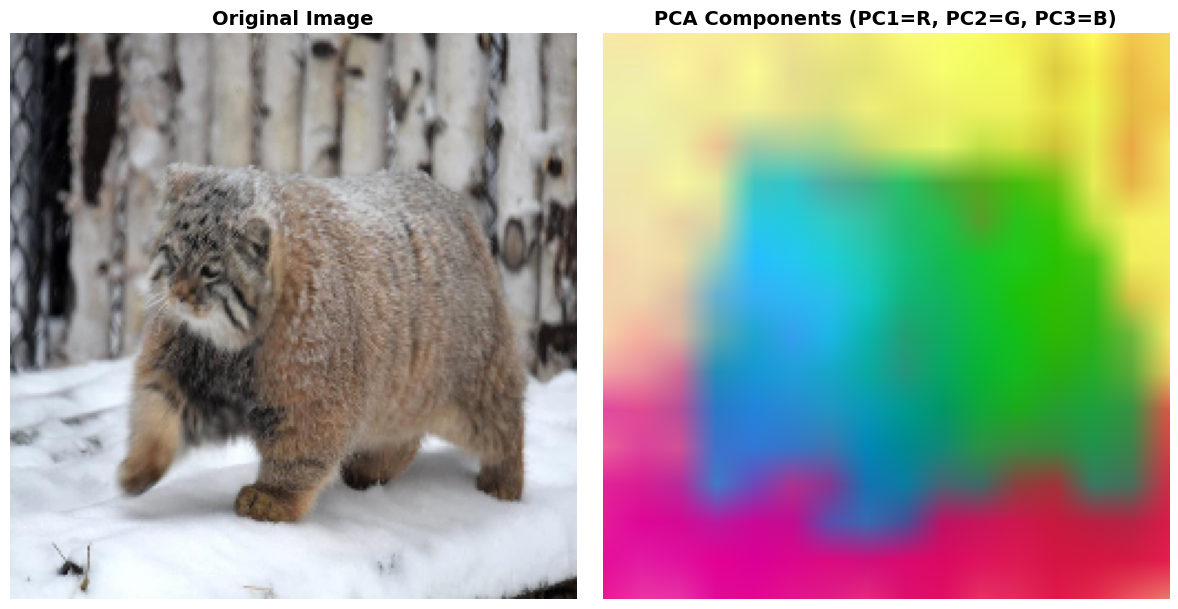

In [4]:
# Alternative: Visualize all 3 components as RGB
# Normalize each component to [0, 1] range
pc1_norm = (pc1 - pc1.min()) / (pc1.max() - pc1.min())
pc2_norm = (pc2 - pc2.min()) / (pc2.max() - pc2.min())
pc3_norm = (pc3 - pc3.min()) / (pc3.max() - pc3.min())

# Stack as RGB channels
pca_rgb = np.stack([pc1_norm, pc2_norm, pc3_norm], axis=-1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(original_image)
axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

# PCA RGB visualization (upsample to match image size for better visualization)
from scipy.ndimage import zoom
print(original_image.shape)
upsample_factor = original_image.shape[0] / patch_size
pca_rgb_upsampled = zoom(pca_rgb, (upsample_factor, upsample_factor, 1), order=1)

axes[1].imshow(pca_rgb_upsampled)
axes[1].set_title('PCA Components (PC1=R, PC2=G, PC3=B)', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()
